In [12]:
import pandas as pd
import numpy as np

#import torch
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

#import pytorch_lightning as pl
import seaborn as sns
from pylab import rcParams

import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from multiprocessing import cpu_count
#from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
#from pytorch_lightning.loggers import TensorBoardLogger
from torchmetrics.functional import accuracy
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

from keras.layers import Conv1D, Dense, Dropout, Input, Concatenate, GlobalMaxPooling1D
from keras.models import Model
from tensorflow import keras
import tensorflow as tf
# from keras.optimizers import RMSprop, adam

## Importing Data

In [313]:
#day1_dataset_1min = pd.read_csv('Data Slices/day1_dataset_1min_10Aug2022.csv')
day1_dataset_10min = pd.read_csv('Data Slices/day1_dataset_10min_10Aug2022.csv')
day1_dataset_30min = pd.read_csv('Data Slices/day1_dataset_30min_10Aug2022.csv')
day1_dataset_60min = pd.read_csv('Data Slices/day1_dataset_60min_10Aug2022.csv')
train_90_10_split = pd.read_csv('C:\\Users\\allep\\SMU_MSDS_CAPSTONE_2022\\train_90_10_split.csv')

In [14]:
def get_X_and_y(df, x_columns, y_columns):
    X = df[x_columns]
    y = df[y_columns]
    return X, y

In [16]:
def get_daily_sequences(X, y, feature_columns, sequence_dict = {}):
    for collection, group in X.groupby("collection"):
        features = group[group.columns.intersection(feature_columns)]
        blacklist = y[y.collection == collection].iloc[0].blacklisted
        if sequence_dict.get(collection):
            sequence_dict[collection][0].append(features)
        else:
            sequence_dict[collection] = ([features], blacklist)
    return sequence_dict

In [17]:
def scale_dataset(sequences, columns = ['Price_USD', 'Price_Crypto', 'volume', 'densities', 'vertex_count', 
                              'edge_count','vertext_edge_ratio'], fitted_scaler = None):
    collection_blacklist_dict = {sequence[0]:sequence[2] for sequence in sequences}
    concat_df = pd.concat([sequence[1] for sequence in sequences])
    if fitted_scaler is None:
        fitted_scaler = StandardScaler()
        fitted_scaler.fit(concat_df[columns])
    concat_df[columns] = fitted_scaler.transform(concat_df[columns])
    return  [(collection, group[columns], collection_blacklist_dict[collection]) 
             for collection, group in concat_df.groupby("collection")] , fitted_scaler

In [18]:
def get_all_sequences(all_df):
    sequence_dict = {}
    for df in all_df: 
        df = df.drop(['Unnamed: 0'], axis=1)
        x_columns =  ['Datetime_updated_seconds','Price_USD','Price_Crypto','volume','densities',
                   'vertex_count','edge_count','collection']
        y_columns = ['blacklisted','collection']
        feature_columns=['Price_USD','Price_Crypto','volume',
                         'densities', 'vertex_count','edge_count', 'collection', 'vertext_edge_ratio']
        X, y= get_X_and_y(df, x_columns, y_columns)
        X['vertext_edge_ratio'] = X['vertex_count']/X['edge_count']
        sequence_dict = get_daily_sequences(X, y, feature_columns, sequence_dict)
    return sequence_dict

In [376]:
def retrieve_all_train_test_sequences(all_df, split_list):
    train_sequences = []
    test_sequences = []
    all_sequence_dict = get_all_sequences(all_df)
    
    for i in range(0,len(test.keys())):
        if list(all_sequence_dict.keys())[i] in list(split_list):
            train_sequences.append(list(all_sequence_dict.items())[i])
        else:
            test_sequences.append(list(all_sequence_dict.items())[i])
#     for train_s
#         scaled_train_sequences, scaler = scale_dataset(train_sequences)
#         scaled_test_sequences ,  _ = scale_dataset(test_sequences, fitted_scale r= scaler)
    return train_sequences, test_sequences

In [377]:
# Without 1min
train_sequences, test_sequences = retrieve_all_train_test_sequences([day1_dataset_10min, day1_dataset_30min, day1_dataset_60min],
                                                                    train_90_10_split['collection'])

C:\Users\allep\anaconda3\envs\MyEnv3_7\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [378]:
# Check that the split worked correctly 
train_collections = []
i_max = len(train_sequences)
for i in range(0, i_max):    
    if train_sequences[i][0] in list(train_90_10_split['collection']):
        train_collections.append(train_sequences[i][0])
len(train_collections)

894

In [396]:
test_collections = []
i_max = len(test_sequences)
for i in range(0, i_max):    
    if test_sequences[i][0] not in list(train_90_10_split['collection']):
        test_collections.append(test_sequences[i][0])
len(test_collections)

101

In [433]:
# No overlap in train/test set collections
len(set(test_collections) - set(train_collections))

101

In [126]:
# With 1min
#train_sequences, test_sequences = retrieve_all_train_test_sequences([day1_dataset_1min, day1_dataset_10min, day1_dataset_30min, day1_dataset_60min])

In [379]:
scaled_train_dataset_dict = {}
scaled_test_dataset_dict = {}
scaled_train_dataset= []
scaled_test_dataset= []
length = 3
for n in range(length):
    train_scaled, scaler = scale_dataset([(sequence[0], sequence[1][0][n], sequence[1][1]) for sequence in
                                          train_sequences])
    test_scaled, _ = scale_dataset([(sequence[0], sequence[1][0][n], sequence[1][1]) for sequence in
                                    test_sequences], fitted_scaler= scaler)
    scaled_train_dataset.append(train_scaled)
    scaled_test_dataset.append(test_scaled)
    
for scale_sequence in scaled_train_dataset:
    for collection in scale_sequence:
        if scaled_train_dataset_dict.get(collection[0]):
            scaled_train_dataset_dict[collection[0]][0].append(collection[1])
        else:
            scaled_train_dataset_dict[collection[0]] = ([collection[1]], collection[2])
    
for scale_sequence in scaled_test_dataset:
    for collection in scale_sequence:
        if scaled_test_dataset_dict.get(collection[0]):
            scaled_test_dataset_dict[collection[0]][0].append(collection[1])
        else:
            scaled_test_dataset_dict[collection[0]] = ([collection[1]], collection[2])

In [ ]:
#len(list(scaled_train_dataset_dict.keys()))

In [ ]:
#len(list(scaled_test_dataset_dict.keys()))

In [ ]:
#list(scaled_test_dataset_dict.values())[1][0][2]

In [ ]:
#list(scaled_train_dataset_dict.values())[1][0][2]

## Model

In [380]:
train_values = list(scaled_train_dataset_dict.values())

In [381]:
test_values = list(scaled_test_dataset_dict.values())

In [382]:
MODEL_SHAPE1  = train_values[0][0][0].shape
MODEL_SHAPE1

(144, 7)

In [383]:
MODEL_SHAPE2  = train_values[0][0][1].shape
MODEL_SHAPE2

(48, 7)

In [384]:
MODEL_SHAPE3 = train_values[0][0][2].shape
MODEL_SHAPE3

(24, 7)

In [385]:
def get_base_model(shape, k_size = K_SIZE1, num_filters = NUM_FILTERS1):
    print("base model shape", shape)
    input_seq = Input(shape=shape)
    nb_filters = num_filters
    convolved = Conv1D(num_filters, k_size, padding="same", activation="relu")(input_seq)
    processed = GlobalMaxPooling1D()(convolved)
    compressed = Dense(50, activation="relu")(processed)
    compressed = Dropout(0.3)(compressed)
    model = Model(inputs=input_seq, outputs=compressed)
    return model

In [386]:
def main_model(shape1, shape2, shape3):
    shape1_input = Input(shape=shape1, name='input1')
    shape2_input = Input(shape=shape2, name='input2')
    shape3_input = Input(shape=shape3, name='input3')
    shape1_model = get_base_model(shape1, k_size = K_SIZE1, num_filters=NUM_FILTERS1)
    shape2_model = get_base_model(shape2, k_size = K_SIZE2, num_filters=NUM_FILTERS2)
    shape3_model = get_base_model(shape3, k_size = K_SIZE3, num_filters=NUM_FILTERS3)
    
    embedding1 = shape1_model(shape1_input)
    embedding2 = shape2_model(shape2_input)
    embedding3 = shape3_model(shape3_input)
    merged = Concatenate()([embedding1, embedding2, embedding3])
    
    # todo: add hidden layers
    out = Dense(1, activation='sigmoid')(merged)
    model = Model(inputs=[shape1_input, shape2_input, shape3_input], outputs=out)
    return model

In [418]:
def run_model(x_train, y_train, x_test, y_test):
    es = keras.callbacks.EarlyStopping(min_delta=0.0000001, patience=40)
    #data_set = tf.data.Dataset.from_tensor_slices(  (x_train ,y_train) )
    model = main_model(MODEL_SHAPE1, MODEL_SHAPE2, MODEL_SHAPE3)
    model.compile(loss='binary_crossentropy', # categorical_crossentropy
                          optimizer='rmsprop', #sgd, nadam, adam, rmsprop
                          metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall(),
                                   tf.keras.metrics.AUC(curve='PR')])
    model.summary()
    print('SIZE OF TRAINING DATA', len(x_train))
    model_hist = model.fit(x_train,
                               validation_data=x_test,
                               batch_size=50, epochs=1000, 
                           callbacks=[es]
                          )
    return model_hist, model

In [388]:
def plot_training_curves_auc(history, title=None, run=None):
    ''' Plot the training curves for loss and accuracy given a model history
    '''
    # find the minimum loss epoch
    minimum = np.min(history.history['val_loss'])
    min_loc = np.where(minimum == history.history['val_loss'])[0]
    # get the vline y-min and y-max
    loss_min, loss_max = (min(history.history['val_loss'] + history.history['loss']),
                          max(history.history['val_loss'] + history.history['loss']))
    acc_min, acc_max = (min(history.history['val_auc'+'_'+run] + history.history['auc'+'_'+run]),
                        max(history.history['val_auc'+'_'+run] + history.history['auc'+'_'+run]))
    # create figure
    fig, ax = plt.subplots(ncols=2, figsize = (15,7))
    fig.suptitle(title)
    index = np.arange(1, len(history.history['auc'+'_'+run]) + 1)
    # plot the loss and validation loss
    ax[0].plot(index, history.history['loss'], label = 'loss')
    ax[0].plot(index, history.history['val_loss'], label = 'val_loss')
    ax[0].vlines(min_loc + 1, loss_min, loss_max, label = 'min_loss_location')
    ax[0].set_title('Loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].legend()
    # plot the accuracy and validation accuracy
    ax[1].plot(index, history.history['auc'+'_'+run], label = 'auc')
    ax[1].plot(index, history.history['val_auc'+'_'+run], label = 'val_auc')
    ax[1].vlines(min_loc + 1, acc_min, acc_max, label = 'min_loss_location')
    ax[1].set_title('AUC')
    ax[1].set_ylabel('auc')
    ax[1].set_xlabel('Epochs')
    ax[1].legend()
    plt.show()

In [389]:
NUM_FILTERS1 = 30
NUM_FILTERS2 = 20
NUM_FILTERS3 = 10
K_SIZE1 = 12 #10
K_SIZE2 = 12 #6
K_SIZE3 = 6 #4

In [421]:
x_train_1 = [sequence[0][0] for sequence in train_values]
x_train_2 = [sequence[0][1] for sequence in train_values]
x_train_3 = [sequence[0][2] for sequence in train_values]
y_train = [sequence[1] for sequence in train_values]

X_train1 = np.stack(x_train_1)
X_train2 = np.stack(x_train_2)
X_train3 = np.stack(x_train_3)

train_len = len(train_sequences)
X_train1 = X_train1.reshape(train_len,144,7)
X_train2 = X_train2.reshape(train_len,48,7)
X_train3 = X_train3.reshape(train_len,24,7)

In [422]:
# Zero-out one or more of the training sets
#X_train1 = np.zeros( (train_len,144,7) , dtype=np.int64)
#X_train2 = np.zeros( (train_len,48,7) , dtype=np.int64)
#X_train3 = np.zeros( (train_len,24,7) , dtype=np.int64)

In [423]:
x_test_1 = [sequence[0][0] for sequence in test_values]
x_test_2 = [sequence[0][1] for sequence in test_values]
x_test_3 = [sequence[0][2] for sequence in test_values]
y_test = [sequence[1] for sequence in test_values]

X_test1 = np.stack(x_test_1)
X_test2 = np.stack(x_test_2)
X_test3 = np.stack(x_test_3)

test_len = len(test_sequences)
X_test1 = X_test1.reshape(test_len,144,7)
X_test2 = X_test2.reshape(test_len,48,7)
X_test3 = X_test3.reshape(test_len,24,7)

In [424]:
# Zero-out one or more of the test sets
#X_test1 = np.zeros( (test_len,144,7) , dtype=np.int64)
#X_test2 = np.zeros( (test_len,48,7) , dtype=np.int64)
#X_test3 = np.zeros( (test_len,24,7) , dtype=np.int64)

In [ ]:
# X_train = [sequence[0].to_numpy() for sequence in scaled_train_sequences]
# y_train = [sequence[1] for sequence in scaled_train_sequences]
# X_test = [sequence[0].to_numpy() for sequence in scaled_test_sequences]
# y_test = [sequence[1] for sequence in scaled_test_sequences]

In [425]:
dataset_train = tf.data.Dataset.from_tensor_slices(({'input1': X_train1, 'input2': X_train2, 'input3': X_train3},
                                                    y_train)).batch(50)

In [426]:
validation = tf.data.Dataset.from_tensor_slices(({'input1': X_test1, 'input2': X_test2, 'input3': X_test3},
                                                 y_test)).batch(50)

In [434]:
model_hist, model = run_model(dataset_train, y_train, validation,  y_test)

base model shape (144, 7)
base model shape (48, 7)
base model shape (24, 7)
Model: "model_235"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input1 (InputLayer)            [(None, 144, 7)]     0           []                               
                                                                                                  
 input2 (InputLayer)            [(None, 48, 7)]      0           []                               
                                                                                                  
 input3 (InputLayer)            [(None, 24, 7)]      0           []                               
                                                                                                  
 model_232 (Functional)         (None, 50)           4100        ['input1[0][0]']                 
              

18/18 [==============================] - 0s 16ms/step - loss: 0.5168 - precision_58: 0.5625 - recall_58: 0.0378 - auc_58: 0.4618 - val_loss: 0.6001 - val_precision_58: 0.0000e+00 - val_recall_58: 0.0000e+00 - val_auc_58: 0.6943
Epoch 25/1000
18/18 [==============================] - 0s 12ms/step - loss: 0.5217 - precision_58: 0.6500 - recall_58: 0.0546 - auc_58: 0.4563 - val_loss: 0.6011 - val_precision_58: 0.0000e+00 - val_recall_58: 0.0000e+00 - val_auc_58: 0.6899
Epoch 26/1000
18/18 [==============================] - 0s 11ms/step - loss: 0.5218 - precision_58: 0.7333 - recall_58: 0.0462 - auc_58: 0.4579 - val_loss: 0.5990 - val_precision_58: 0.0000e+00 - val_recall_58: 0.0000e+00 - val_auc_58: 0.6988
Epoch 27/1000
18/18 [==============================] - 0s 12ms/step - loss: 0.5183 - precision_58: 0.5263 - recall_58: 0.0420 - auc_58: 0.4580 - val_loss: 0.5985 - val_precision_58: 0.0000e+00 - val_recall_58: 0.0000e+00 - val_auc_58: 0.6933
Epoch 28/1000
18/18 [=========================

18/18 [==============================] - 0s 11ms/step - loss: 0.4779 - precision_58: 0.8000 - recall_58: 0.2353 - auc_58: 0.5743 - val_loss: 0.5959 - val_precision_58: 0.7500 - val_recall_58: 0.0811 - val_auc_58: 0.6197
Epoch 59/1000
18/18 [==============================] - 0s 11ms/step - loss: 0.4764 - precision_58: 0.7467 - recall_58: 0.2353 - auc_58: 0.5706 - val_loss: 0.5963 - val_precision_58: 0.7500 - val_recall_58: 0.0811 - val_auc_58: 0.6214
Epoch 60/1000
18/18 [==============================] - 0s 13ms/step - loss: 0.4725 - precision_58: 0.7703 - recall_58: 0.2395 - auc_58: 0.5875 - val_loss: 0.5958 - val_precision_58: 0.7500 - val_recall_58: 0.0811 - val_auc_58: 0.6042
Epoch 61/1000
18/18 [==============================] - 0s 18ms/step - loss: 0.4687 - precision_58: 0.7887 - recall_58: 0.2353 - auc_58: 0.5932 - val_loss: 0.5959 - val_precision_58: 0.7500 - val_recall_58: 0.0811 - val_auc_58: 0.6171
Epoch 62/1000
18/18 [==============================] - 0s 18ms/step - loss: 0.

18/18 [==============================] - 0s 17ms/step - loss: 0.4310 - precision_58: 0.7959 - recall_58: 0.3277 - auc_58: 0.6592 - val_loss: 0.5973 - val_precision_58: 0.8000 - val_recall_58: 0.1081 - val_auc_58: 0.5829
Epoch 94/1000
18/18 [==============================] - 0s 15ms/step - loss: 0.4263 - precision_58: 0.8081 - recall_58: 0.3361 - auc_58: 0.6671 - val_loss: 0.6214 - val_precision_58: 0.5714 - val_recall_58: 0.1081 - val_auc_58: 0.5458


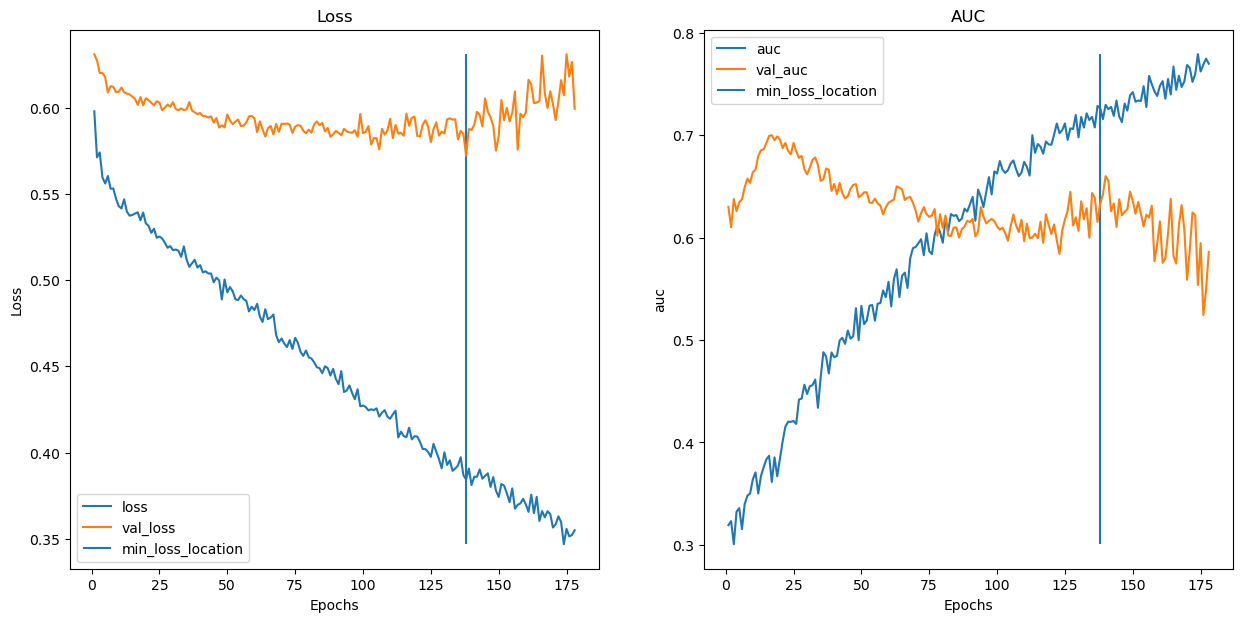

In [432]:
plot_training_curves_auc(history=model_hist, run='57')

In [42]:
#prediction = model.predict(all_x_test)

In [ ]:
#prediction[prediction <=0.5] = 0
#prediction[prediction >0.5] = 1

In [ ]:
#[pred[0] for pred in prediction.tolist()]